File structure
Folder and files in main directory:
- model.py
- Behavior-Cloning.ipynb
- model.json
- model.h5
- drive.py
- driving_log.csv
- 'IMG' folder
    -- 'All .jpg images'

In [1]:
import sys
sys.path.append('c:\\users\\valery\\miniconda3\\envs\\tensorflow-gpu\\Lib\\site-packages')
sys.path.append('c:\\users\\valery\\miniconda3\\envs\\tensorflow-gpu\\Lib\\site-packages\\sklearn\\feature_extraction')

In [2]:
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


In [3]:
# Get training dataset from Udacity website

# Imports
from urllib.request import urlretrieve
from os.path import isfile
from tqdm import tqdm
import zipfile
import shutil

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile('driving_log.csv'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Train Dataset') as pbar:
        urlretrieve(
            'https://d17h27t6h515a5.cloudfront.net/topher/2016/December/584f6edd_data/data.zip',
            'data.zip',
            pbar.hook)

    # Unzip data set
    zip_ref = zipfile.ZipFile('data.zip', 'r')
    zip_ref.extractall('')
    zip_ref.close()

    # Move dataset to folder location
    shutil.move('data/IMG/','IMG')
    shutil.move('data/driving_log.csv','driving_log.csv')
    
    print('Training data downloaded.')

In [4]:
# Imports
import pickle
import numpy as np
import math

# Fix error with TF and Keras
import tensorflow as tf

In [5]:
"""Sources: https://github.com/fchollet/keras/blob/master/keras/preprocessing/image.py"""

# Preprocessing functions for image set

# Imports
import cv2
import math
from sklearn.utils import shuffle
import numpy as np
import scipy.ndimage as ndi

# Shuffle image set
def shuffle_set(all_angles, imgs_fname):
    return shuffle(all_angles, imgs_fname)

# Preprocess image
def preprocess_img(img,angle):  
    img = np.squeeze(img)
    img = yuv_img(img)
    img = crop_img(img)
    img = resize_img(img)
    img,angle_p = random_transform(img,angle)
    img_p = np.expand_dims(img, axis=0)
    return img_p,angle_p

# Transform BGR to YUV
def yuv_img(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2YUV)

# Crop image
def crop_img(img):
    y1,y2,x1,x2 = 60,120,0,320
    return img[y1:y2,x1:x2]

# Resize image
def resize_img(img):
    return cv2.resize(img,(img_length,img_height))

# Random transform to image
def random_transform(img, angle):
    
    img_row_axis = 0
    img_col_axis = 1
    img_channel_axis = 2

    # Rotation
    rotation_range = 15
    theta = np.pi / 180 * np.random.uniform(-rotation_range, rotation_range)
    
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta), 0],
                                [np.sin(theta), np.cos(theta), 0],
                                [0, 0, 1]])
    angle = angle + theta/2

    
    # Shift horizontal and vertical
    height_shift_range = 0.3
    tx = np.random.uniform(-height_shift_range, height_shift_range) * img.shape[img_row_axis]
    
    width_shift_range = 0.3
    ty = np.random.uniform(-width_shift_range, width_shift_range) * img.shape[img_col_axis]
    
    translation_matrix = np.array([[1, 0, tx],
                                   [0, 1, ty],
                                   [0, 0, 1]])

    angle = angle + math.atan(-ty/(img.shape[img_row_axis]+tx))
    
    # Transformation
    h, w = img.shape[img_row_axis], img.shape[img_col_axis]
    
    transform_matrix = np.dot(rotation_matrix,translation_matrix)
    transform_matrix = transform_matrix_offset_center(transform_matrix, h, w)
    img = apply_transform(img, transform_matrix, img_channel_axis)
    
    # Horizontal flip
    if np.random.random() < 0.5:
        img = flip_axis(img, img_col_axis)
        angle = -1 * angle
        
    return img, angle
        

def transform_matrix_offset_center(matrix, x, y):
    o_x = float(x) / 2 + 0.5
    o_y = float(y) / 2 + 0.5
    offset_matrix = np.array([[1, 0, o_x], [0, 1, o_y], [0, 0, 1]])
    reset_matrix = np.array([[1, 0, -o_x], [0, 1, -o_y], [0, 0, 1]])
    transform_matrix = np.dot(np.dot(offset_matrix, matrix), reset_matrix)
    
    return transform_matrix
    

def apply_transform(x, transform_matrix, channel_axis=0, fill_mode='nearest', cval=0.):
    x = np.rollaxis(x, channel_axis, 0)
    final_affine_matrix = transform_matrix[:2, :2]
    final_offset = transform_matrix[:2, 2]
    channel_images = [ndi.interpolation.affine_transform(x_channel, final_affine_matrix,
                                                         final_offset, order=0, mode=fill_mode, cval=cval) for x_channel in x]
    x = np.stack(channel_images, axis=0)
    x = np.rollaxis(x, 0, channel_axis + 1)

    return x

def flip_axis(x, axis):
    x = np.asarray(x).swapaxes(axis, 0)
    x = x[::-1, ...]
    x = x.swapaxes(0, axis)

    return x

In [6]:
# Load and one-hot all angles (labels)

# Imports
import csv, sys
import os
from sklearn.preprocessing import LabelBinarizer
from keras.utils.np_utils import to_categorical

filename = 'driving_log.csv'
all_angles = []
imgs_fname = []

with open(filename, 'rt') as csvfile:
    
    # Load driving angle data
    anglereader = csv.reader(csvfile, delimiter=',')

    try:
        for row in anglereader:
            all_angles.append(float(row[-4]))
          
            fln = row[0].split('/')
            imgs_fname.append(fln[-1])
    except csv.Error as e:
        sys.exit('file %s, line %d: %s' % (filename, reader.line_num, e))
    
    
    
    # Total number of unique angles data
    num_uniq_ang = len(np.unique(all_angles))    
    num_all_ang = len(all_angles)  
            
    # Shuffle data set
    all_angles, imgs_fname = shuffle_set(all_angles, imgs_fname)
    
print('All angles data loaded.')

All angles data loaded.


In [7]:
# Load images and driving log data for each batch

# Imports
import os
import os.path
from PIL import Image
import numpy as np

# Total number of images
num_all_img = len(os.listdir(os.getcwd()+'/IMG'))

def load_data_batch(batch_num,batch_size,all_angles, imgs_fname, img_height, img_length):
    
    img_folder_path = os.getcwd()+'\\IMG'
    valid_ext = [".jpg"]

    imgs = np.empty((0,img_height,img_length,3))
    angles = []
    angles = all_angles[batch_num*batch_size:(batch_num+1)*batch_size]
    imgs_fname_batch  = imgs_fname[batch_num*batch_size:(batch_num+1)*batch_size]
    
    for f in imgs_fname_batch:
        img_path = os.path.join(img_folder_path,f)
        img = Image.open(img_path)
        img,angles[imgs.shape[0]] = preprocess_img(img,angles[imgs.shape[0]])
        imgs = np.append(imgs,img,axis=0)

    imgs = imgs.astype(np.uint8)

    return imgs, angles

In [8]:
# Define train and validation batch generators

# Imports
import math
import os
import random

# Hyper Parameters
epoch = 1

# Pick samples per epoch = num_all_ang
samples_per_epoch = math.floor(num_all_ang/64)*64

# Pick batch_size = 64
batch_size = 64

train_valid_split = 0.8
nb_val_samples = samples_per_epoch*(1-train_valid_split)

# Resized image shape
img_height = 64
img_length = 64
img_ch = 3

# Batch parameters
batch_train_max = math.floor(train_valid_split*num_all_ang/batch_size)
batch_validation_max = math.floor(num_all_ang/batch_size)
nb_val_samples = math.floor((1-train_valid_split)*num_all_ang)

def generate_train_batch(batch_size):
    # Generate data batch
    while 1:
        for batch_num in range (0,batch_train_max):
            X_train_ba, y_train_ba = load_data_batch(batch_num,batch_size,
                                                     all_angles,imgs_fname,
                                                     img_height,img_length)
            if batch_num == (batch_train_max-1):
                batch_num = 0
            
            print()
            
            yield X_train_ba, y_train_ba

def generate_validation_batch(batch_size):
    # Generate data batch
    batch_range = batch_validation_max - batch_train_max
    while 1:
        for batch_num in range (0,batch_range):
            batch_val_num = batch_num + batch_train_max

            X_validation_ba, y_validation_ba = load_data_batch(batch_num,batch_size,
                                                               all_angles,imgs_fname,
                                                               img_height, img_length)          
            if batch_num == (batch_range-1):
                batch_num = 0
            
            yield X_validation_ba, y_validation_ba

In [9]:
# CHOOSE TO IMPORT MODEL AND WEIGHTS
# OPTIONAL: import model_train.json and model_train.h5

# Imports
import json
from keras.models import model_from_json

# Load the model from model.json
json_data=open('model.json').read()
json_string = json.loads(json_data)
model = model_from_json(json_string)

#Load the weights from model.h5
model.load_weights('model.h5', by_name=True)

"""
sources:
https://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf
"""

# Imports
from keras.models import Sequential
from keras.layers.core import Lambda, Dense, Activation, Dropout, Flatten 
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D

row, col, ch = img_height,img_length,img_ch

#nvidia model
model = Sequential()               
model.add(Lambda(lambda x: x/127.5 - 1.,
                 input_shape=(row,col,ch),
                 output_shape=(row,col,ch)))

model.add(Convolution2D(24,5,5,border_mode='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(1,1)))

model.add(Convolution2D(36,5,5,border_mode='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(1,1)))

model.add(Convolution2D(48,5,5,border_mode='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(1,1)))

model.add(Convolution2D(64,3,3,border_mode='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(1,1)))

model.add(Convolution2D(64,3,3,border_mode='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(1,1)))

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Activation('relu'))

model.add(Dense(1164))
model.add(Dropout(0.5))
model.add(Activation('relu'))

model.add(Dense(100))
model.add(Dropout(0.5))
model.add(Activation('relu'))

model.add(Dense(50))
model.add(Dropout(0.5))
model.add(Activation('relu'))

model.add(Dense(10))
model.add(Dropout(0.5))
model.add(Activation('relu'))

model.add(Dense(1))

In [10]:
# Imports
from keras.optimizers import Adam

# Compile and train the model
model.compile(loss='mean_squared_error',optimizer=Adam(lr=0.0001))
model.summary()
history = model.fit_generator(generate_train_batch(batch_size),
                              samples_per_epoch = samples_per_epoch, nb_epoch = epoch, 
                              validation_data = generate_validation_batch(batch_size),
                              nb_val_samples = nb_val_samples, verbose = 1, max_q_size=10)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 64, 64, 3)     0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 64, 24)    1824        lambda_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 64, 64, 24)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 63, 63, 24)    0           activation_1[0][0]               
___________________________________________________________________________________________

In [11]:
# Save the model and weights

# Imports
from keras.models import model_from_json
import json

# Save the model to model.json
json_string = model.to_json()
with open('model.json', 'w') as f:
     json.dump(json_string, f)

# Save the weights to model.h5
model.save_weights('model.h5')


In [12]:
from keras import backend as K
K.clear_session()

# CHOOSE TO IMPORT MODEL AND WEIGHTS
# OPTIONAL: import model_train.json and model_train.h5

# Imports
import json
from keras.models import model_from_json

# Load the model from model.json
json_data=open('model.json').read()
json_string = json.loads(json_data)
model = model_from_json(json_string)

#### for Otto model
# Load the model from model.json
#json_data=open('model_otto.json').read()
#model = model_from_json(json_data)
####

#Load the weights from model.h5
model.load_weights('model.h5', by_name=True)

right_2016_12_01_13_45_12_716.jpg
-0.1826526162461313


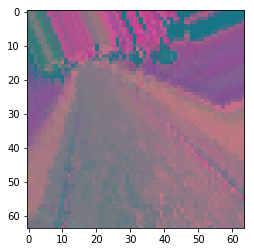

In [13]:
# Test Cells below
import matplotlib.pyplot as plt

all_angles, imgs_fname = shuffle_set(all_angles, imgs_fname)
all_angles1 = all_angles[0:1]
imgs_fname1 = imgs_fname[0:1]
print(imgs_fname1[0])
test_imgs, test_angle = load_data_batch(0,1,all_angles1, imgs_fname1,img_height,img_length)
image = test_imgs[0]

print(test_angle[0])

plt.imshow(image)
plt.show()


In [14]:
print()
image_p = image[None, :, :, :]
predicted_angle = float(model.predict(image_p, verbose=1))
print("Predicted angle value: ",predicted_angle)
print("Predicted angle: ",predicted_angle/0.04)
print("Expected angle value: ",test_angle[0])
print("Expected angle: ",float(test_angle[0])/0.04)
print(np.argmax(predicted_angle))


1/1 [==============================] - 0s
Predicted angle value:  -0.18753895163536072
Predicted angle:  -4.688473790884018
Expected angle value:  -0.1826526162461313
Expected angle:  -4.566315406153282
0
